In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Jupyter Demo").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

24/01/15 20:37:28 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
24/01/15 20:37:28 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/01/15 20:37:35 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/15 20:38:08 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install plotly
#!pip install seaborn
#!pip install dash
#!pip install geojson

In [3]:
import os
import pandas as pd
import plotly.express as px
from pyspark.sql.functions import col
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import numpy as np

In [4]:
# load Eurostat code mappers
path = '/home/vagrant/data/eurostat_codes'
codes_euro = {'_'.join(col.split('_')[1:-1]).lower() : pd.read_csv(os.path.join(path, col), sep='\t') for col in os.listdir(path)}
codes_euro = {key : dict(zip(val.iloc[:,0],val.iloc[:,1])) for key, val in codes_euro.items()}

In [5]:
# func to map results df codes
def map_code(df, codes=codes_euro):
    cols_to_map = [col for col in df.columns if col.lower() in codes.keys()]
    for col in cols_to_map:
        df[col] = df[col].replace(codes[col.lower()])
    return df

In [6]:
# load data
ac = spark.read.option("header","true").option("inferschema","true").parquet("hdfs://localhost:8020/users/test/project/env_ac_ainah_r2_linear.parquet")
ac = ac.withColumn("OBS_VALUE", col("OBS_VALUE.member1").cast("double "))
chdd = spark.read.option("header","true").option("inferschema","true").parquet("hdfs://localhost:8020/users/test/project/nrg_chdd_a_linear.parquet")

In [7]:
ac.show()

+--------------------+-----------------+----+------+-------+-----+---+-----------+----------------+--------+
|            DATAFLOW|      LAST_UPDATE|freq|airpol|nace_r2| unit|geo|TIME_PERIOD|       OBS_VALUE|OBS_FLAG|
+--------------------+-----------------+----+------+-------+-----+---+-----------+----------------+--------+
|ESTAT:ENV_AC_AINA...|20/12/23 23:00:00|   A|   ACG|      A|G_HAB| AT|       2008|14934.7998046875|    null|
|ESTAT:ENV_AC_AINA...|20/12/23 23:00:00|   A|   ACG|      A|G_HAB| AT|       2009|15210.5498046875|    null|
|ESTAT:ENV_AC_AINA...|20/12/23 23:00:00|   A|   ACG|      A|G_HAB| AT|       2010|15068.6298828125|    null|
|ESTAT:ENV_AC_AINA...|20/12/23 23:00:00|   A|   ACG|      A|G_HAB| AT|       2011|  14986.16015625|    null|
|ESTAT:ENV_AC_AINA...|20/12/23 23:00:00|   A|   ACG|      A|G_HAB| AT|       2012| 15004.400390625|    null|
|ESTAT:ENV_AC_AINA...|20/12/23 23:00:00|   A|   ACG|      A|G_HAB| AT|       2013| 14945.919921875|    null|
|ESTAT:ENV_AC_AINA.

In [8]:
chdd.printSchema()

root
 |-- DATAFLOW: string (nullable = true)
 |-- LAST_UPDATE: string (nullable = true)
 |-- freq: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- indic_nrg: string (nullable = true)
 |-- geo: string (nullable = true)
 |-- TIME_PERIOD: integer (nullable = true)
 |-- OBS_VALUE: double (nullable = true)
 |-- OBS_FLAG: string (nullable = true)



In [9]:
# distinct values in column
ac.select('unit').distinct().collect()

[Row(unit='T'), Row(unit='THS_T'), Row(unit='G_HAB'), Row(unit='KG_HAB')]

In [10]:
# data for plot 1
plot1_data = ac.filter((col("airpol") == "CO2") & ( col("nace_r2") == "TOTAL") & (col("unit") == "KG_HAB")).groupBy("TIME_PERIOD", "geo").agg({"OBS_VALUE": "sum"}).toPandas()

In [11]:
# plot 1
plot1_data = plot1_data.sort_values(by='TIME_PERIOD')
plot1_data = map_code(plot1_data)
fig = px.line(plot1_data, x='TIME_PERIOD', y='sum(OBS_VALUE)', color='geo',
              labels={'sum(OBS_VALUE)': 'Total CO2 Emissions', 'TIME_PERIOD': 'Year', 'geo': 'Region'})

fig.update_layout(title='CO2 Emissions by region',
                  xaxis_title='Year',
                  yaxis_title='Total CO2 Emissions')

fig.show()

In [12]:
# Calculate corelation matrix
ac_martix = ac.select(col('airpol'),col('geo'),col('TIME_PERIOD'),col('OBS_VALUE')).filter((col("nace_r2") == "TOTAL") & (col("unit") == "T")).withColumnRenamed('airpol','var')
chdd_matrix = chdd.select(col('indic_nrg'),col('geo'),col('TIME_PERIOD'),col('OBS_VALUE')).filter(col("unit") == "NR").withColumnRenamed('indic_nrg','var')
matrix = ac_martix.union(chdd_matrix)
matrix = matrix.groupBy("TIME_PERIOD","geo").pivot("var").sum("OBS_VALUE")
matrix = matrix.toPandas()
matrix = map_code(matrix)
# Map column names
matrix.columns = map_code(map_code(pd.DataFrame(matrix.columns,columns=['airpol'])).rename({'airpol': 'indic_nrg'}, axis=1)).iloc[:,0].to_list()

In [31]:
m = matrix.sort_values(['geo', 'TIME_PERIOD']).set_index('TIME_PERIOD')
correlation_matrices = m.groupby('geo').corr()
# Plot the correlation matrix for each 'geo' using Plotly
for geo_value, correlation_matrix in correlation_matrices.groupby(level=0):
    # Drop the 'geo' column from the correlation matrix
    correlation_matrix = correlation_matrix.droplevel('geo')
    
    chdd_cols = ['Cooling degree days', 'Heating degree days']
    
    correlation_matrix = correlation_matrix.drop(chdd_cols,axis=1).drop(correlation_matrix.columns.difference(chdd_cols),axis=0)

    # Create a heatmap using Plotly Express
    fig = px.imshow(
        correlation_matrix,
        labels=dict(color="Correlation"),
        title=f"Correlation Matrix for Geo: {geo_value}"
    )

    # Show the heatmap
    fig.show()

In [39]:
m.loc[m.geo=='Malta',['Perfluorocarbones (CO2 equivalent)','Cooling degree days']]

Perfluorocarbones (CO2 equivalent)  Cooling degree days
TIME_PERIOD                                                         
1979                                        NaN               432.58
1980                                        NaN               284.96
1981                                        NaN               399.25
1982                                        NaN               587.77
1983                                        NaN               454.95
1984                                        NaN               336.84
1985                                        NaN               423.49
1986                                        NaN               440.47
1987                                        NaN               639.14
1988                                        NaN               582.54
1989                                        NaN               455.52
1990                                        NaN               589.53
1991                                        NaN               513.78
1992                                        NaN               479.38
1993                                        NaN               542.32
1994                                        NaN               676.80
1995                                        NaN               601.42
1996                                        NaN               494.38
1997                                        NaN               584.61
1998                                        NaN               650.61
1999                                        NaN               754.98
2000                                        NaN               608.79
2001                                        NaN               659.06
2002                                        NaN               559.24
2003                                        NaN               740.22
2004                                        NaN               477.84
2005                                        NaN               475.39
2006                                        NaN               599.01
2007                                        NaN               617.71
2008                                        NaN               548.60
2009                                        NaN               575.55
2010                                        NaN               499.13
2011                                        NaN               534.56
2012                                        NaN               781.30
2013                                        NaN               629.65
2014                                        NaN               648.46
2015                                        NaN               685.34
2016                                        NaN               611.05
2017                                        NaN               673.11
2018                                        NaN               625.61
2019                                        NaN               756.22
2020                                        NaN               672.27
2021                                       9.59               793.36
2022                                      17.26               841.72

In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

m = matrix.sort_values(['geo', 'TIME_PERIOD']).set_index('TIME_PERIOD')
correlation_matrices = m.groupby('geo').corr()

# Create subplots
fig = make_subplots(
    rows=1,
    cols=correlation_matrices.index.get_level_values(0).unique().shape[0],
    shared_xaxes=True,
    shared_yaxes=True,
    subplot_titles=correlation_matrices.index.get_level_values(0).unique(),
)

# Add heatmaps to subplots
for i, (geo_value, correlation_matrix) in enumerate(correlation_matrices.groupby(level=0)):
  # Drop the 'geo' column from the correlation matrix
    correlation_matrix = correlation_matrix.droplevel('geo')
    
    chdd_cols = ['Cooling degree days', 'Heating degree days']
    
    correlation_matrix = correlation_matrix.drop(chdd_cols,axis=0).drop(correlation_matrix.columns.difference(chdd_cols),axis=1)
    
    heatmap = go.Heatmap(
        x = correlation_matrix.columns,
        y = correlation_matrix.index,
        z = correlation_matrix.values,
       coloraxis='coloraxis'
    )
    fig.add_trace(heatmap, row=1, col=i + 1)

# Update layout
fig.update_layout(
    title_text="Correlation Matrices for Different Regions",
    height=800,
    width=3000,
    coloraxis = {'colorscale':'viridis'}
)

# rotate all the subtitles of 90 degrees
for annotation in fig['layout']['annotations']: 
        annotation['textangle']=-45

# Show the plot
fig.show()

# Scatterplot 

## Cooling degree days

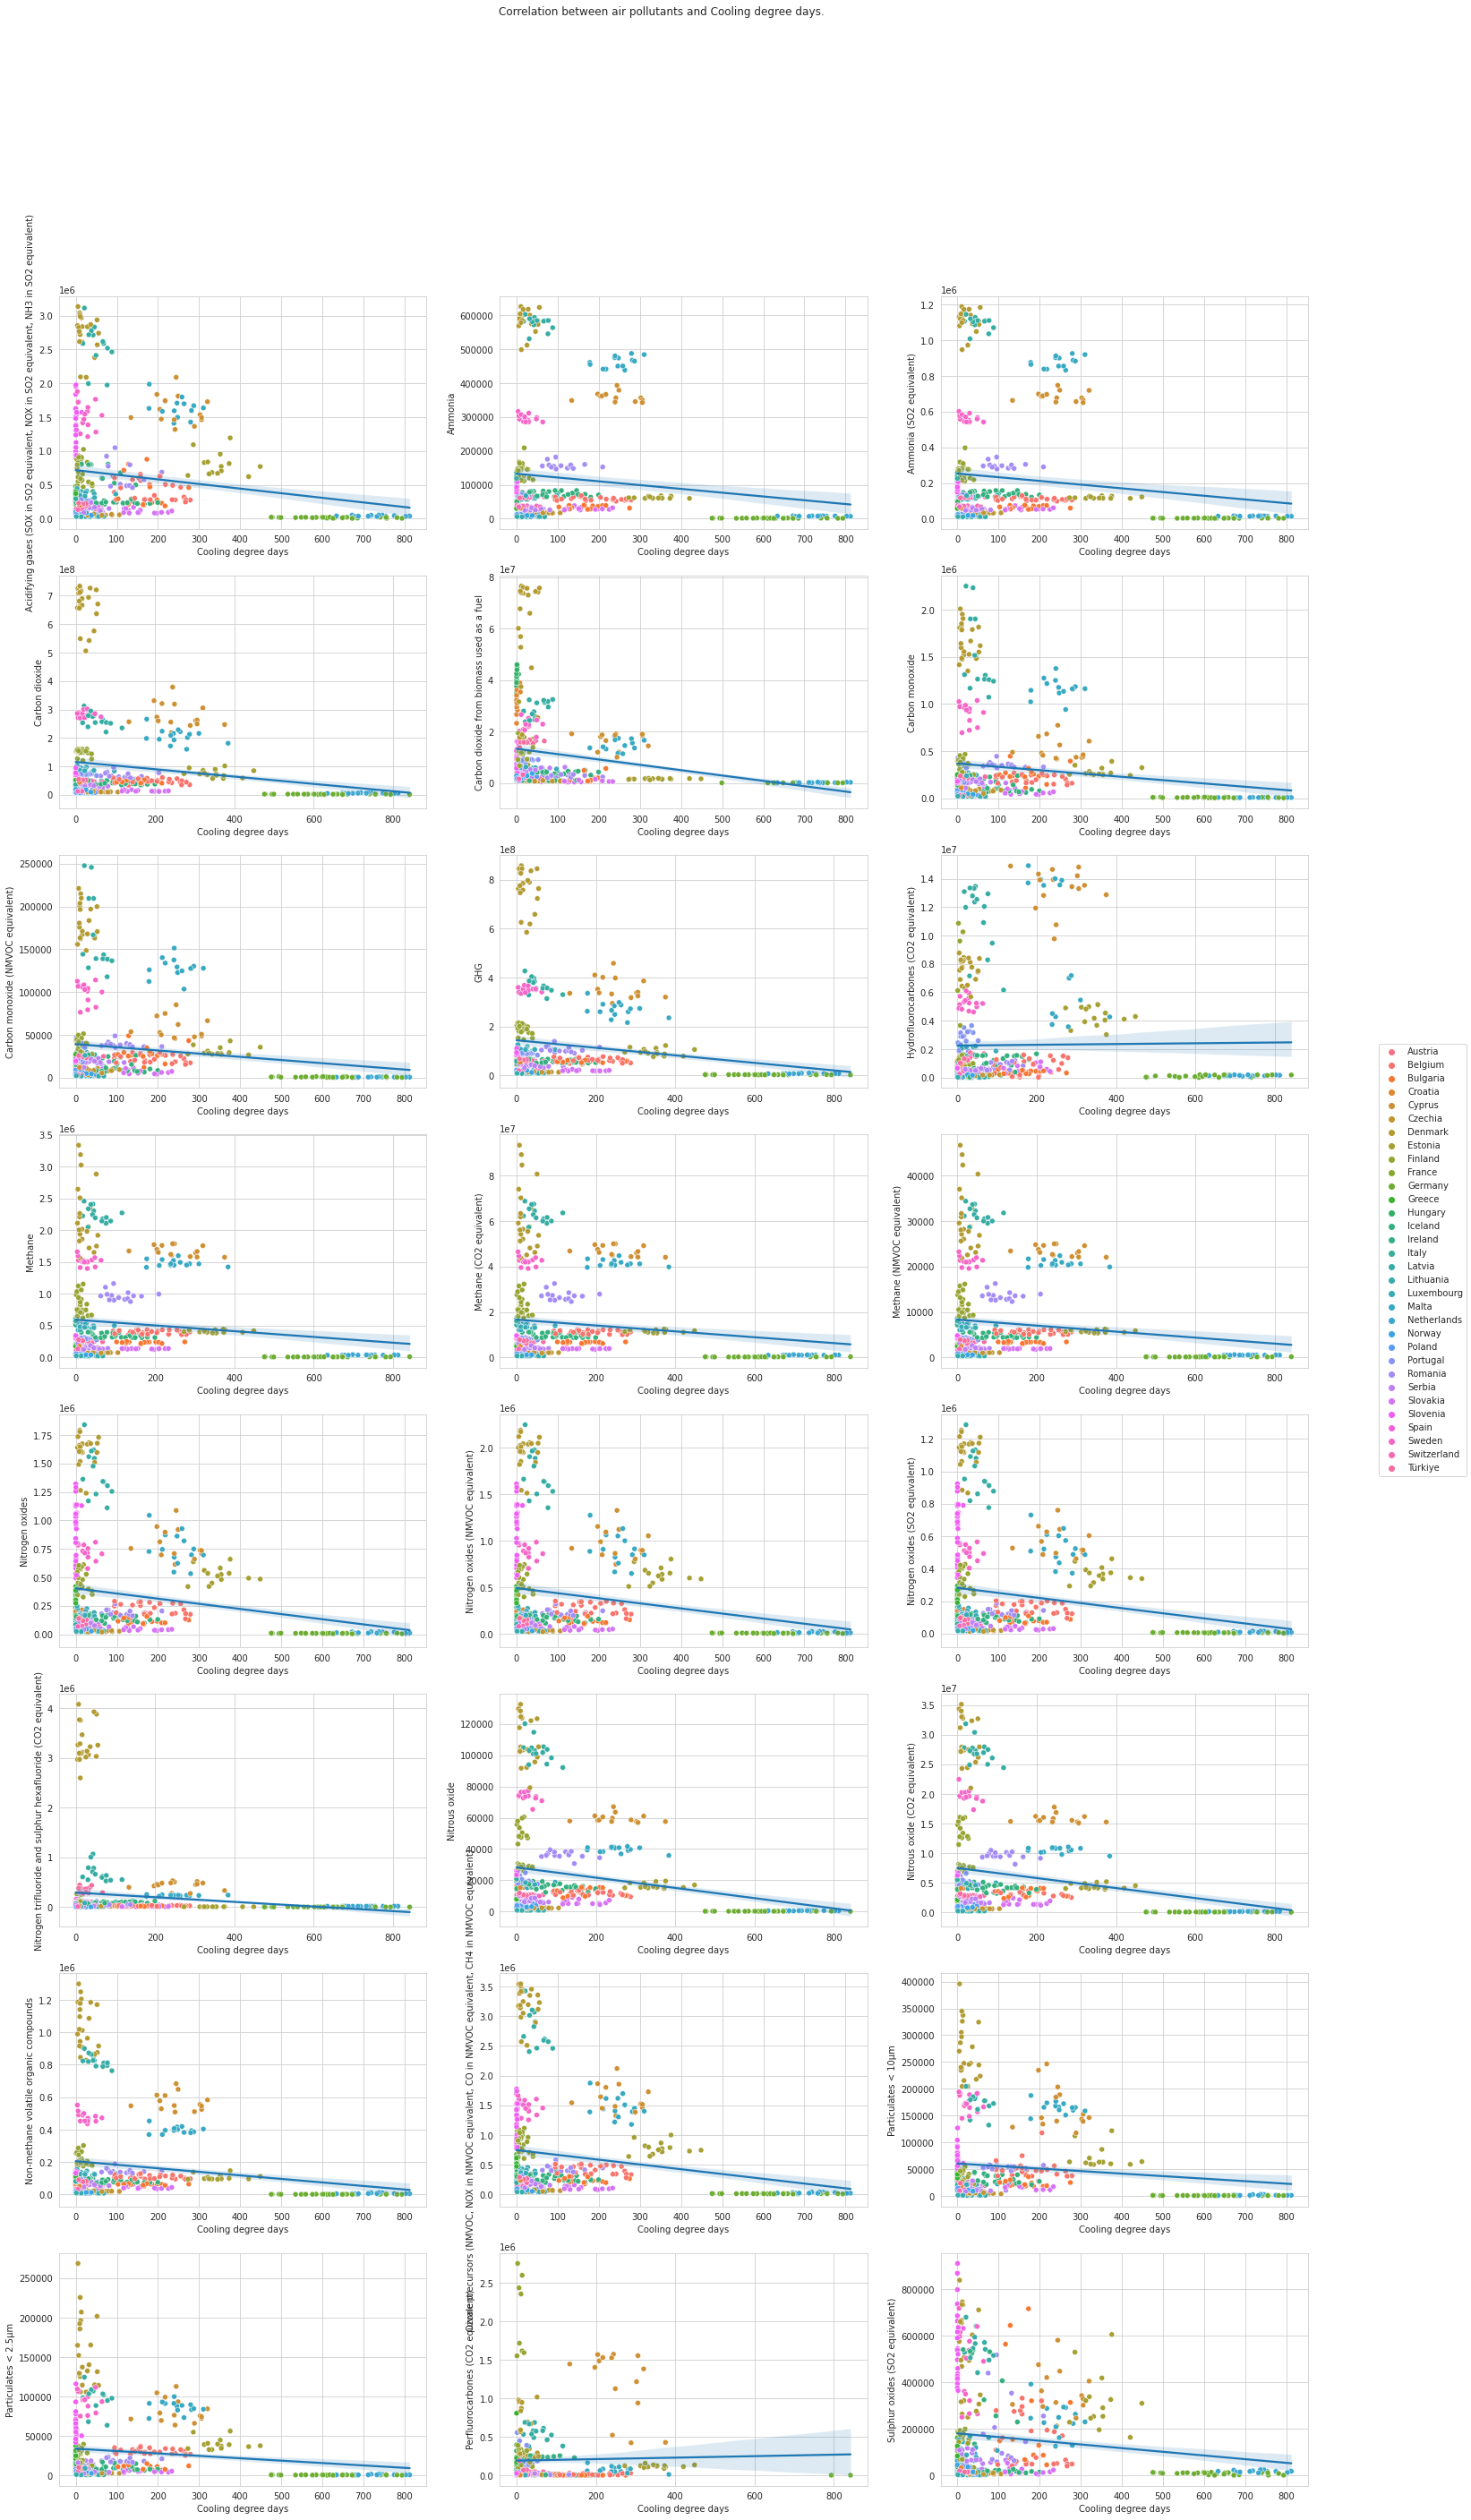

In [35]:
df1 = matrix[matrix["geo"] != 'European Union - 27 countries (from 2020)']
chdd_cols = ['Cooling degree days', 'Heating degree days']
atmosphere_col = df1.columns.difference(['Cooling degree days', 'Heating degree days', 'TIME_PERIOD', 'geo'])

row_number = 8
col_number = 3


#set seaborn plotting aesthetics as default
sns.set_style(style='whitegrid')

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(row_number, col_number, figsize=(25, 45))
a = 0

for i in range(row_number):
    for j in range(col_number):     
        atm_col = atmosphere_col[a]
        
        if (a==0):
            scatter_plot = sns.scatterplot(x=chdd_cols[0], y=atm_col, data=df1, hue='geo', ax=axes[i,j])  
            handles, labels = axes[0,0].get_legend_handles_labels()
            axes[0,0].legend().set_visible(False)         
        else:
            scatter_plot = sns.scatterplot(x=chdd_cols[0], y=atm_col, data=df1, hue='geo', ax=axes[i,j], legend=False) 
        sns.regplot(x=chdd_cols[0], y=atm_col, data=df1, ax=axes[i,j], scatter = False)
        a+=1

    
labels = np.unique(labels)
fig.legend(handles, labels, loc='center right')
fig.suptitle("Correlation between air pollutants and Cooling degree days. ")

fig.show()

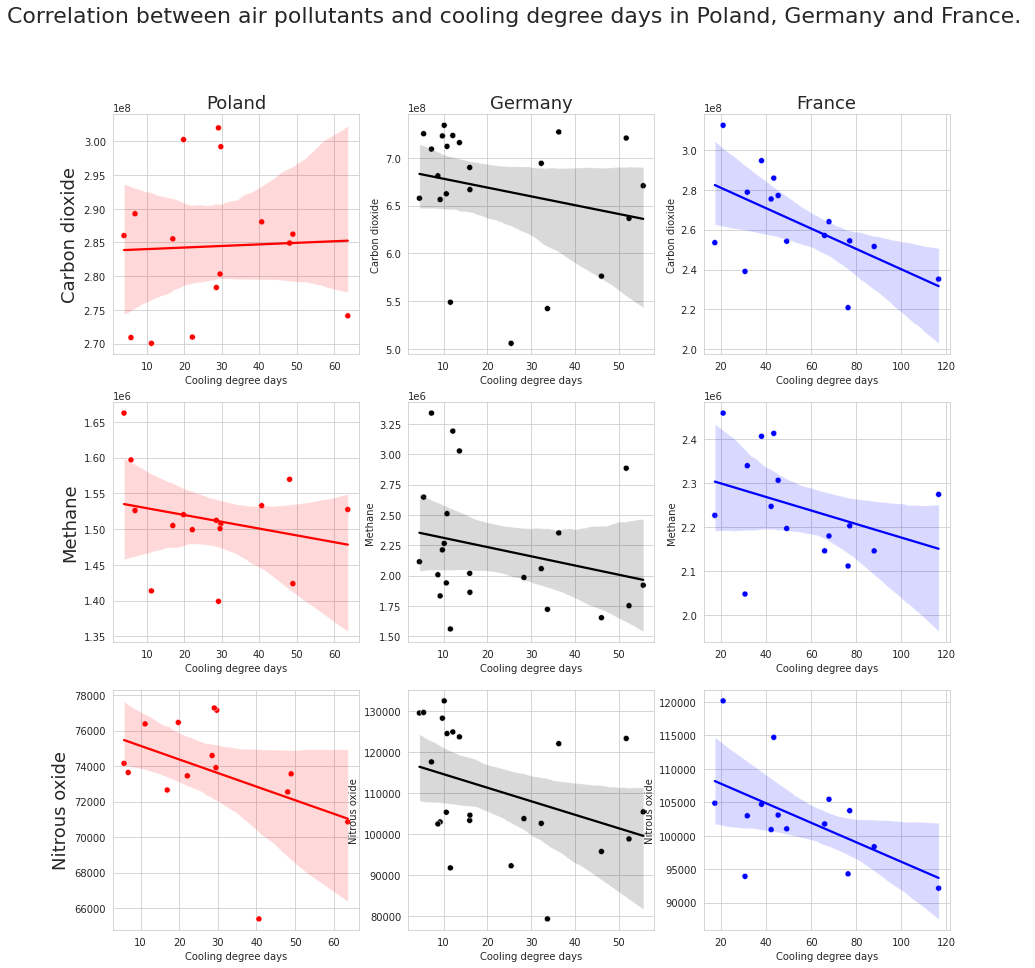

In [201]:
df1 = matrix[matrix["geo"] != 'European Union - 27 countries (from 2020)']

chdd_cols = ['Cooling degree days', 'Heating degree days']
atmosphere_col = ['Carbon dioxide', 'Methane', 'Nitrous oxide']
countries = ["Poland", "Germany", "France"]
color = ["red", "black", "blue"]

row_number = 3
col_number = 3


#set seaborn plotting aesthetics as default
sns.set_style(style='whitegrid')

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(row_number, col_number, figsize=(15, 15))

for i in range(row_number):
    for j in range(col_number):     
        plot_df = df1[df1["geo"]==countries[j]]
        atm_col = atmosphere_col[i]
        
        scatter_plot = sns.scatterplot(x=chdd_cols[0], y=atm_col, data=plot_df, hue='geo', palette=[color[j]], ax=axes[i,j], legend=False) 
        sns.regplot(x=chdd_cols[0], y=atm_col, data=plot_df, ax=axes[i,j], scatter = False, color=color[j])

axes[0, 0].set_title(countries[0], fontsize = 18)
axes[0, 1].set_title(countries[1], fontsize = 18) 
axes[0, 2].set_title(countries[2], fontsize = 18)

axes[0, 0].set_ylabel(atmosphere_col[0], fontsize = 18)
axes[1, 0].set_ylabel(atmosphere_col[1], fontsize = 18) 
axes[2, 0].set_ylabel(atmosphere_col[2], fontsize = 18)
fig.suptitle("Correlation between air pollutants and cooling degree days in Poland, Germany and France. ", fontsize = 22)

fig.show()

## Heating degree days

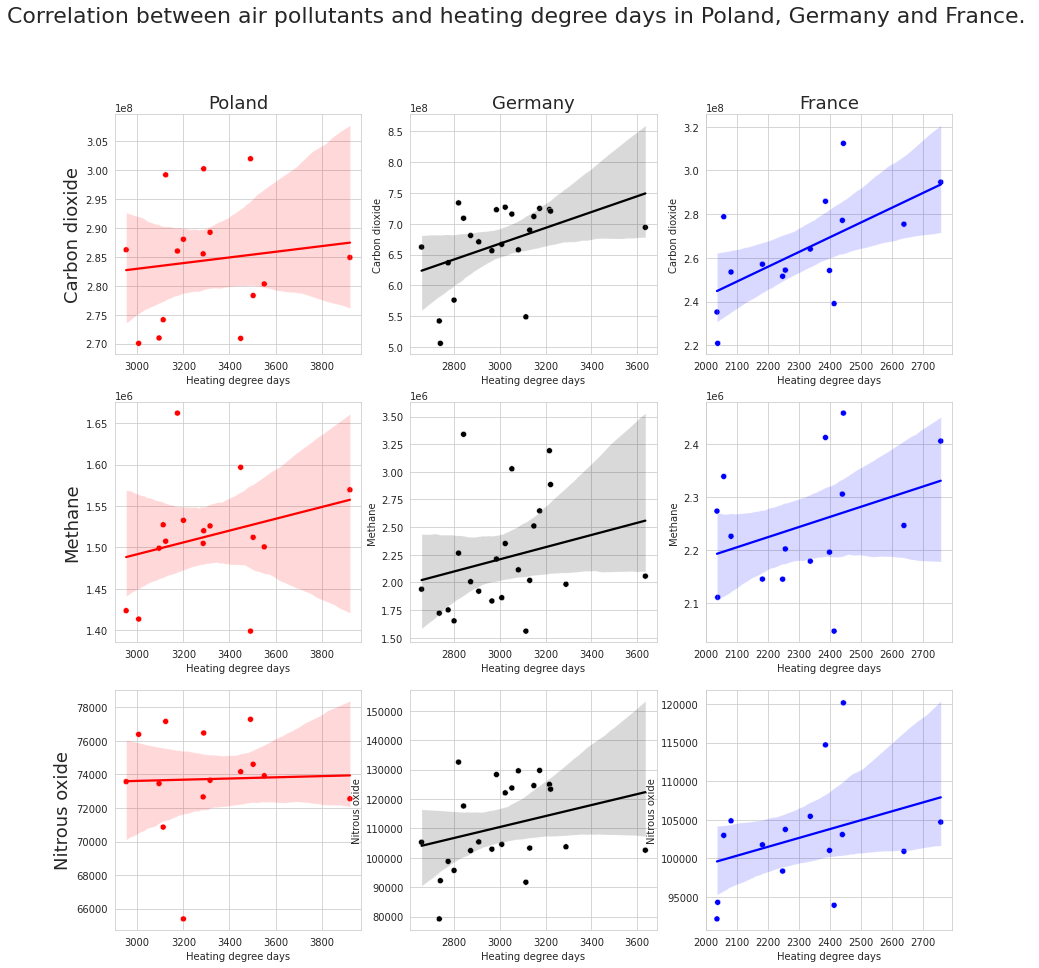

In [203]:
df1 = matrix[matrix["geo"] != 'European Union - 27 countries (from 2020)']

chdd_cols = ['Cooling degree days', 'Heating degree days']
atmosphere_col = ['Carbon dioxide', 'Methane', 'Nitrous oxide']
countries = ["Poland", "Germany", "France"]
color = ["red", "black", "blue"]

row_number = 3
col_number = 3


#set seaborn plotting aesthetics as default
sns.set_style(style='whitegrid')

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(row_number, col_number, figsize=(15, 15))

for i in range(row_number):
    for j in range(col_number):     
        plot_df = df1[df1["geo"]==countries[j]]
        atm_col = atmosphere_col[i]
        
        scatter_plot = sns.scatterplot(x=chdd_cols[1], y=atm_col, data=plot_df, hue='geo', palette=[color[j]], ax=axes[i,j], legend=False) 
        sns.regplot(x=chdd_cols[1], y=atm_col, data=plot_df, ax=axes[i,j], scatter = False, color=color[j])

axes[0, 0].set_title(countries[0], fontsize = 18)
axes[0, 1].set_title(countries[1], fontsize = 18) 
axes[0, 2].set_title(countries[2], fontsize = 18)

axes[0, 0].set_ylabel(atmosphere_col[0], fontsize = 18)
axes[1, 0].set_ylabel(atmosphere_col[1], fontsize = 18) 
axes[2, 0].set_ylabel(atmosphere_col[2], fontsize = 18)
fig.suptitle("Correlation between air pollutants and heating degree days in Poland, Germany and France. ", fontsize = 22)

fig.show()

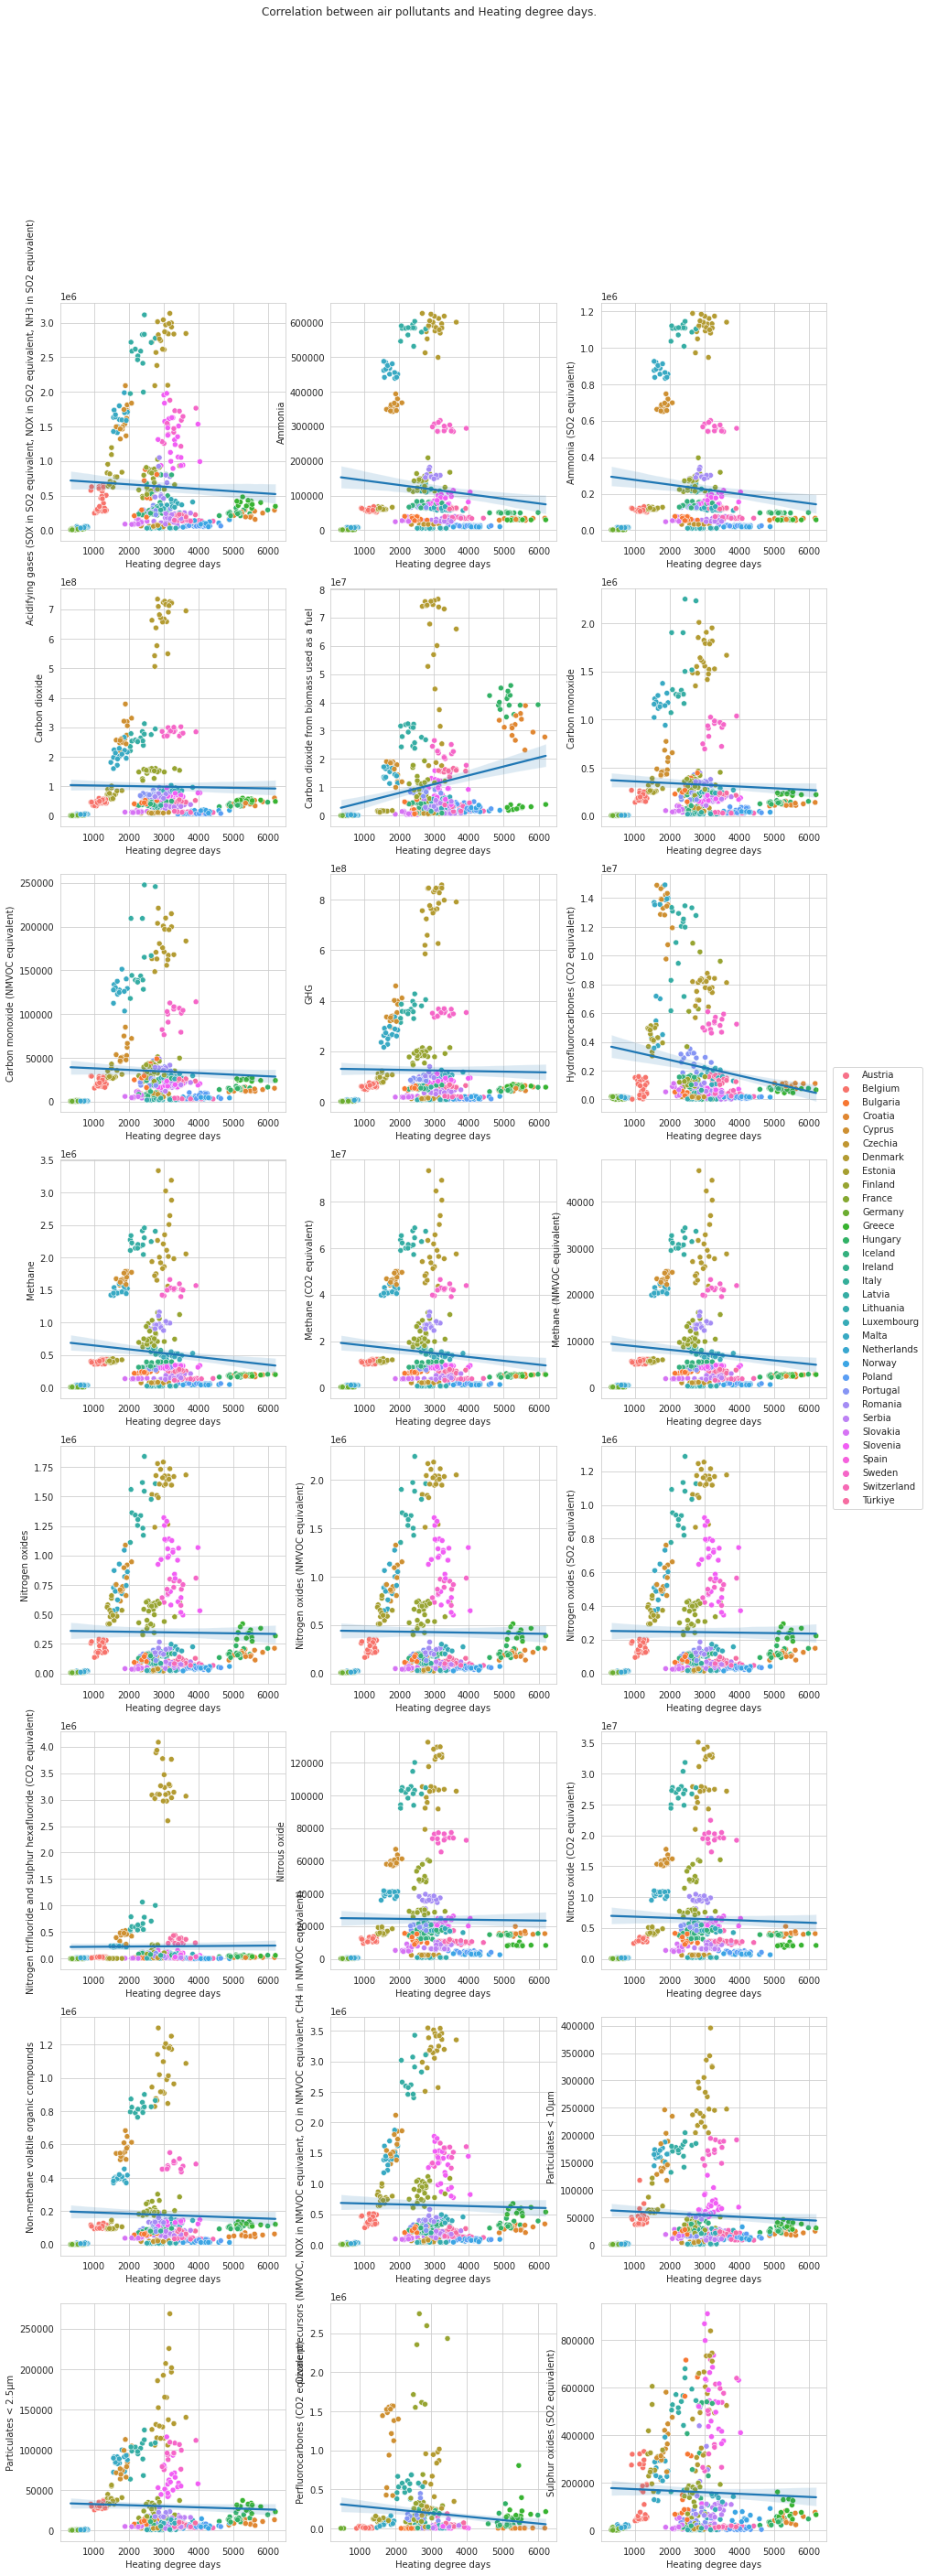

In [14]:
df1 = matrix[matrix["geo"] != 'European Union - 27 countries (from 2020)']
chdd_cols = ['Cooling degree days', 'Heating degree days']
atmosphere_col = df1.columns.difference(['Cooling degree days', 'Heating degree days', 'TIME_PERIOD', 'geo'])

row_number = 8
col_number = 3


#set seaborn plotting aesthetics as default
sns.set_style(style='whitegrid')

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(row_number, col_number, figsize=(25, 45))
a = 0

for i in range(row_number):
    for j in range(col_number):     
        atm_col = atmosphere_col[a]
        if (a==0):
            scatter_plot = sns.scatterplot(x=chdd_cols[1], y=atm_col, data=df1, hue='geo', ax=axes[i,j])  
            handles, labels = axes[0,0].get_legend_handles_labels()
            axes[0,0].legend().set_visible(False)
        else:
            scatter_plot = sns.scatterplot(x=chdd_cols[1], y=atm_col, data=df1, hue='geo', ax=axes[i,j], legend=False)  
        sns.regplot(x=chdd_cols[1], y=atm_col, data=df1, ax=axes[i,j], scatter = False)
        a+=1

    
labels = np.unique(labels)
fig.legend(handles, labels, loc='center right')
fig.suptitle("Correlation between air pollutants and Heating degree days. ")

fig.show()

# Dashboard

In [15]:
import geojson
geojson_file = "/home/vagrant/data/custom.geo.json"
with open(geojson_file) as f:
    gj = geojson.load(f)
features = gj['features'][0]

## Corelation

In [192]:
map_df = matrix[matrix["geo"]!="European Union - 27 countries (from 2020)"]
chdd_cols = ['Cooling degree days', 'Heating degree days']
atmosphere_col = map_df.columns.difference(['Cooling degree days', 'Heating degree days', 'TIME_PERIOD', 'geo'])
years = map_df['TIME_PERIOD'].unique()

map_width = 1000
map_height = 700

print("Start app")
app = Dash(__name__)


app.layout = html.Div([
    html.H4('Corellation between air pollutants and cooling/heating in Europe'),
    html.P("Choose cooling or heating: "),
    dcc.RadioItems(
        id='chdd_cols', 
        options=chdd_cols,
        value=chdd_cols[0],
        inline=True
    ),
    html.P("Choose air pollutant: "),
    dcc.Dropdown(
        id='atmosphere_col', 
        options=atmosphere_col,
        value=atmosphere_col[0]
    ),
    dcc.Graph(id="graph", figure={}, style={'width': f'{map_width}px', 'height': f'{map_height}px'}),
])

@app.callback(
    Output("graph", "figure"), 
    Input("chdd_cols", "value"),
    Input("atmosphere_col", "value"))
def display_choropleth(chdd_cols, atmosphere_col):
    #df = matrix # replace with your own data source
    geojson = gj
    
    df = map_df[["geo", chdd_cols, atmosphere_col]]
    df = df.groupby("geo").corr()
    df = df[atmosphere_col].to_frame().reset_index()
    df = df.rename(columns={"level_1": chdd_cols, atmosphere_col: "Correlation"})
    df = df[df[chdd_cols]==chdd_cols].reset_index(drop=True)
    
    
    fig = px.choropleth(
        df, 
        geojson=geojson, 
        color="Correlation",
        featureidkey="properties.name_en", 
        locations="geo", 
        projection="mercator", 
        scope="world",
        height=map_height,
        width=map_width, 
        #center=dict({"lat": 500, "lon":540})
        fitbounds="locations", 
        color_continuous_scale="Viridis"
        )
    
    fig.update_layout(height=map_height,
                    width=map_width,
                     margin={"r":0,"t":0,"l":0,"b":0}
                     )
                    #coloraxis_colorbar=dict(title="unemployment rate"))
    fig.layout.coloraxis.colorbar.title = 'Correlation coefficient'
    fig.layout.legend = go.layout.Legend({
    'tracegroupgap': 0, 
    'title': 'Poziom zanieczyszczenia<br>dla wybranej substancji 2 ', 
    'itemsizing': "constant", 
    'itemwidth': 30, 
    
    })
    
    return fig

if __name__ == '__main__':
    app.run_server(jupyter_mode="external", host="10.0.2.15", port="8050", debug=False)

Start app
Dash app running on http://10.0.2.15:8050/


## Air poputants

In [190]:
map_df = matrix[matrix["geo"]!="European Union - 27 countries (from 2020)"]
chdd_cols = ['Cooling degree days', 'Heating degree days']
atmosphere_col = map_df.columns.difference(['Cooling degree days', 'Heating degree days', 'TIME_PERIOD', 'geo'])
years = map_df['TIME_PERIOD'].unique()

map_width = 1000
map_height = 700

print("Start app")
app1 = Dash(__name__)


app1.layout = html.Div([
    html.H4('Air pollutant on the European map'),
    html.P("Choose air pollutant: "),
    dcc.Dropdown(
        id='atmosphere_col', 
        options=atmosphere_col,
        value=atmosphere_col[0]
    ),
    html.P("Choose year: "),
    dcc.Slider(
        id='year',
        step=None, 
        marks={int(year): f"{int(year)}" for year in years},
        value=years.max()
    ),
    dcc.Graph(id="graph", figure={}, style={'width': f'{map_width}px', 'height': f'{map_height}px'}),
])

@app1.callback(
    Output("graph", "figure"), 
    Input("atmosphere_col", "value"), 
    Input("year", "value"))
def display_choropleth(atmosphere_col, year):
    #df = matrix # replace with your own data source
    geojson = gj
    df = map_df[map_df["TIME_PERIOD"]==year]
    fig = px.choropleth(
        df, 
        geojson=geojson, 
        color=atmosphere_col,
        featureidkey="properties.sovereignt", 
        locations="geo", 
        projection="mercator", 
        scope="world",
        height=map_height,
        width=map_width, 
        #center=dict({"lat": 500, "lon":540})
        fitbounds="locations", 
        color_continuous_scale="Viridis"
        )
    
    fig.update_layout(height=map_height,
                    width=map_width,
                     margin={"r":0,"t":0,"l":0,"b":0}
                     )
                    #coloraxis_colorbar=dict(title="unemployment rate"))
    fig.layout.coloraxis.colorbar.title = 'Air pollution<br>for selected pullutant'
    fig.layout.legend = go.layout.Legend({
    'tracegroupgap': 0, 
    #'title': 'Poziom zanieczyszczenia<br>dla wybranej substancji ', 
    'itemsizing': "constant", 
    'itemwidth': 30, 
    
    })
    
    return fig

if __name__ == '__main__':
    app1.run(jupyter_mode="external", host="10.0.2.15", port="8050", debug=False)

Start app
Dash app running on http://10.0.2.15:8050/


## Cooling heating

In [195]:
map_df = matrix[matrix["geo"]!="European Union - 27 countries (from 2020)"]
chdd_cols = ['Cooling degree days', 'Heating degree days']
atmosphere_col = map_df.columns.difference(['Cooling degree days', 'Heating degree days', 'TIME_PERIOD', 'geo'])
years = map_df['TIME_PERIOD'].unique()

map_width = 1000
map_height = 800

print("Start app")
app = Dash(__name__)


app.layout = html.Div([
    html.H4('Cooling/heating in Europe'),
    #html.P(":"),
    dcc.RadioItems(
        id='chdd_cols', 
        options=chdd_cols,
        value=chdd_cols[0],
        inline=True
    ),
    dcc.Slider(
        id='year',
        step=None, 
        marks={int(year): f"{int(year)}" for year in years},
        value=years.max()
    ),
    dcc.Graph(id="graph", figure={}, style={'width': f'{map_width}px', 'height': f'{map_height}px'}),
])

print(atmosphere_col[0])
@app.callback(
    Output("graph", "figure"), 
    Input("chdd_cols", "value"), 
    Input("year", "value"))
def display_choropleth(chdd_cols, year):
    #df = matrix # replace with your own data source
    geojson = gj
    df = map_df[map_df["TIME_PERIOD"]==year]
    fig = px.choropleth(
        df, 
        geojson=geojson, 
        color=chdd_cols,
        featureidkey="properties.sovereignt", 
        locations="geo", 
        projection="mercator", 
        scope="world",
        height=map_height,
        width=map_width, 
        #center=dict({"lat": 500, "lon":540})
        fitbounds="locations", 
        color_continuous_scale="Viridis"
        )
    
    fig.update_layout(height=map_height,
                    width=map_width,
                     margin={"r":0,"t":0,"l":0,"b":0}
                     )
                    #coloraxis_colorbar=dict(title="unemployment rate"))
    fig.layout.coloraxis.colorbar.title = chdd_cols
    fig.layout.legend = go.layout.Legend({
    'tracegroupgap': 0, 
    'title': f'{chdd_cols}', 
    'itemsizing': "constant", 
    'itemwidth': 30, 
    
    })
    
    return fig

if __name__ == '__main__':
    app.run(jupyter_mode="external", host="10.0.2.15", port="8050")

Start app
Acidifying gases (SOX in SO2 equivalent, NOX in SO2 equivalent, NH3 in SO2 equivalent)
Dash app running on http://10.0.2.15:8050/
